## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
data  = pd.read_csv('C:/Users/Amir Hossein/Desktop/Project/dataset/My-Data.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
y = pd.DataFrame(y)

In [3]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor


class GenRF:

    def __init__(self, X, y):
        
        
        self.X = X
        self.y = y


        # split the data, creating a group of training/validation sets to be used in the k-fold validation process:
#         self.kfold = KFold(n_splits=3)

        pipeline = Pipeline([("scaler", StandardScaler()),
                             ("model", RandomForestRegressor())])
        self.model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
        self.RKFold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

    def __len__(self):
        """
        :return: the total number of features used in this Regression problem
        """
        return self.X.shape[1]

    def getMeanR2(self, zeroOneList):
        """
        returns the mean r2 measure of the regressor, calculated using repeated-k-fold validation process,
        using the features selected by the zeroOneList
        :param zeroOneList: a list of binary values corresponding the features in the dataset. A value of '1'
        represents selecting the corresponding feature, while a value of '0' means that the feature is dropped.
        :return: the mean R2 measure of the Regressor when using the features selected by the zeroOneList
        """

        # drop the dataset columns that correspond to the unselected features:
        zeroIndices = [i for i, n in enumerate(zeroOneList) if n == 0]
        currentX = self.X.drop(self.X.columns[zeroIndices], axis=1)

        # perform k-fold validation and determine the accuracy measure of the classifier:
        cv_results = cross_val_score(self.model, currentX, self.y, cv=5, scoring='r2', n_jobs=-1)

        # return mean accuracy:
        return np.mean(cv_results)

def main():
    # create a problem instance:
    rf = GenRF(X, y)

    allOnes = [1] * len(rf)
    print("-- All features selected: ", allOnes, ", r2 = ", rf.getMeanR2(allOnes))


if __name__ == "__main__":
    main()

-- All features selected:  [1, 1, 1, 1, 1] , r2 =  0.9470465363097963


gen	nevals	max     	avg     
0  	100   	0.947778	0.652747 133.20577970007434
Time:  133.20577970007434
1  	67    	0.948566	0.787224
Time:  118.95372499991208
2  	66    	0.94845 	0.821523
Time:  117.08100050012581
3  	67    	0.948713	0.835733
Time:  132.39056689990684
4  	67    	0.948927	0.848391
Time:  132.61114980001003
5  	69    	0.948893	0.853569
Time:  151.961886000121
6  	65    	0.948856	0.853364
Time:  141.06652440014295
7  	69    	0.949817	0.861001
Time:  152.53775560017675
8  	61    	0.948779	0.854407
Time:  128.09017380001023
9  	64    	0.948624	0.859883
Time:  142.7592821000144
10 	67    	0.949272	0.864166
Time:  144.5296213000547
11 	69    	0.948993	0.866131
Time:  158.17059440002777
12 	69    	0.94923 	0.867641
Time:  153.99710070015863
13 	68    	0.949094	0.869547
Time:  146.2726356999483
14 	69    	0.948823	0.868992
Time:  162.67451280006208
15 	66    	0.949178	0.870831
Time:  152.30774089996703
16 	67    	0.948724	0.863128
Time:  138.74719629995525
17 	69    	0.949351	0.

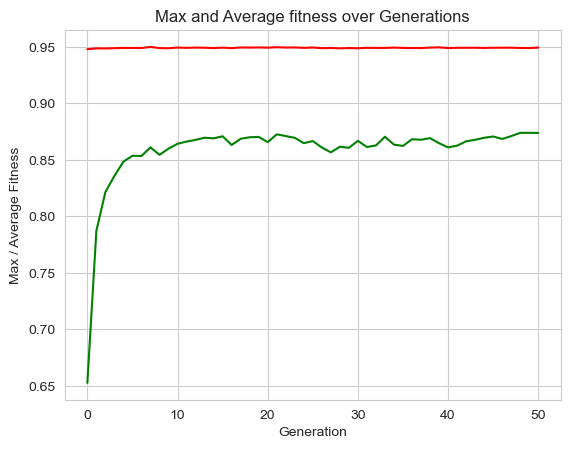

In [4]:
from deap import base, tools, algorithms, creator
from elitism import eaSimpleWithElitism
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Genetic Algorithm constants:
POPULATION_SIZE = 100
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 50
FEATURE_PENALTY_FACTOR = 0.001
HALL_OF_FAME_SIZE = 30

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# X, y = get_data(GSO_FLOW)

tree =GenRF(X, y)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("zeroOrOne", random.randint, a=0, b=1)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(tree))
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

def getR2(individual):
    numFeatureUsed = sum(individual)
    if numFeatureUsed == 0:
        return 0.0,
    else:
        r2_score = tree.getMeanR2(individual)
        return r2_score,

toolbox.register("evaluate", getR2)

toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/276)

population = toolbox.populationCreator(n=POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    
population, logbook = eaSimpleWithElitism(population, toolbox,
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True)

print("- Best solutions are:")
for i in range(5):
    print(i, ": ", hof.items[i], ", fitness = ", hof.items[i].fitness.values[0],
          ", R2Score = ", tree.getMeanR2(hof.items[i]), ", features = ", sum(hof.items[i]))

maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.savefig("C:/Users/Amir Hossein/Desktop/Project/Figures//ga_rf", dpi=1000)
plt.show()